In [8]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# import optuna

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision

import time

import random
from PIL import Image
import cv2

In [9]:
%cd /home/spyros/Desktop/DNN/
data = pd.read_csv('data_enum.csv')
data

/home/spyros/Desktop/DNN


,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
0,HAM_0001751,ISIC_0024698,nv,consensus,70,male,face,False,HAM10000_images_part_1/nv/ISIC_0024698.jpg,1
1,HAM_0000559,ISIC_0024693,nv,follow_up,45,female,upper extremity,False,HAM10000_images_part_1/nv/ISIC_0024693.jpg,1
2,HAM_0004932,ISIC_0032212,nv,follow_up,45,female,foot,False,HAM10000_images_part_2/nv/ISIC_0032212.jpg,1
3,HAM_0004516,ISIC_0025775,nv,follow_up,45,female,neck,False,HAM10000_images_part_1/nv/ISIC_0025775.jpg,1
4,HAM_0006510,ISIC_0029828,nv,follow_up,55,female,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0029828.jpg,1
...,...,...,...,...,...,...,...,...,...,...
30900,HAM_0003141,ISIC_0031918,akiec,histo,65,male,neck,False,HAM10000_images_part_2/akiec/ISIC_0031918.jpg,6
30901,HAM_0001036,ISIC_0027588,akiec,histo,50,female,face,False,HAM10000_images_part_1/akiec/ISIC_0027588.jpg,6
30902,HAM_0001152,ISIC_0030133,akiec,histo,65,male,face,False,HAM10000_images_part_2/akiec/ISIC_0030133.jpg,6
30903,HAM_0002012,ISIC_0026327,akiec,histo,55,female,upper extremity,False,HAM10000_images_part_1/akiec/ISIC_0026327.jpg,6


# Preprocessing

**Normalize function**

In [10]:
img_h, img_w = 224, 224

In [11]:
def compute_img_mean_std(image_paths,img_h,img_w):
    """
    Computing the mean and standard deviation of three channels on the whole dataset,
    without loading all images into memory at once. More time consuming but does not 
    fill up all the RAM.

    Args: image_paths (list): list of image paths
          img_h (int): height in pixels to resize
          img_w (int): width in pixels to resize

    Returns: 
        means (list): mean values of RGB channels
        stdevs (list): standard deviations of RGB channels
    """
    n_images = len(image_paths)
    channel_sum = np.zeros(3)
    channel_sum_squared = np.zeros(3)

    for path in tqdm(image_paths):
        img = cv2.imread(path) # Default BGR image
        img = cv2.resize(img, (img_h, img_w)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGR to RGB
        img = img.astype(np.float32) / 255.0

        channel_sum += np.sum(img, axis=(0, 1))
        channel_sum_squared += np.sum(np.square(img), axis=(0, 1))

    # Calculate mean and standard deviation
    means = channel_sum / (img_h * img_w * n_images)
    stdevs = np.sqrt(channel_sum_squared / (img_h * img_w * n_images) - np.square(means))

    print("Means = {}".format(means))
    print("Stds = {}".format(stdevs))
    return means, stdevs

In [12]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

In [13]:
norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

**Data Augmentation and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [14]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [15]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
0,HAM_0001751,ISIC_0024698,nv,consensus,70,male,face,False,HAM10000_images_part_1/nv/ISIC_0024698.jpg,1
1,HAM_0000559,ISIC_0024693,nv,follow_up,45,female,upper extremity,False,HAM10000_images_part_1/nv/ISIC_0024693.jpg,1
2,HAM_0004932,ISIC_0032212,nv,follow_up,45,female,foot,False,HAM10000_images_part_2/nv/ISIC_0032212.jpg,1
3,HAM_0004516,ISIC_0025775,nv,follow_up,45,female,neck,False,HAM10000_images_part_1/nv/ISIC_0025775.jpg,1
4,HAM_0006510,ISIC_0029828,nv,follow_up,55,female,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0029828.jpg,1


**Data Loading**

In [16]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx_cat',img_col='image_path', transform=None):
        self.data = data
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx][self.img_col]
        image = Image.open(image_path) #RGB format

        label = torch.tensor(self.data.iloc[idx][self.label_column])

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=val_test_transform)
test_dataset = HAM10000Dataset(test_data, transform=val_test_transform)

In [18]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data Len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data Len Train: 18543 Val: 6181 Test: 6181


**Batch check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


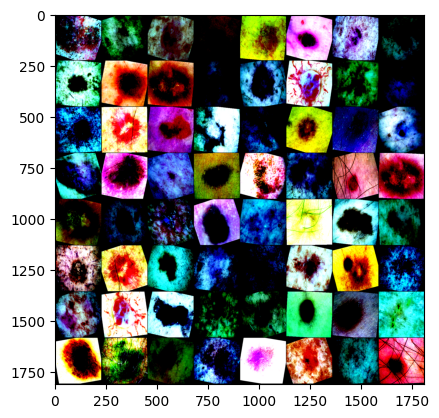

Labels:  tensor([6, 5, 5, 4, 0, 4, 5, 0, 6, 1, 2, 0, 5, 4, 0, 0, 0, 2, 0, 5, 6, 2, 2, 4,
        5, 0, 5, 1, 3, 5, 4, 2, 2, 3, 6, 0, 5, 2, 6, 5, 6, 2, 3, 5, 6, 5, 2, 0,
        6, 4, 0, 5, 5, 4, 2, 5, 1, 3, 4, 3, 2, 6, 5, 1])


In [19]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

# Make the custom model

In [20]:
num_classes = 7

In [21]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(16),            
        nn.ReLU(),            
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = x.view(-1, 3, img_h, img_w)
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        out = out4.view(out4.size(0), -1) #makes them flat
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

CNN_model = CNNet()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [23]:
CNN_model = CNN_model.to(device)
input_size = (3, 224, 224)
summary(CNN_model, input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-3)

In [25]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy


In [26]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(val_loader)
    valid_accuracy = 100 * correct / total
    return avg_valid_loss, valid_accuracy


In [27]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy


In [28]:
min_valid_loss = np.inf
epochs = 10

total_loss_train = []
total_loss_val = []
total_acc_train = []
total_acc_val = []

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(CNN_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_epoch(CNN_model, val_loader, criterion, device)

    total_loss_train.append(train_loss)
    total_loss_val.append(valid_loss)
    total_acc_train.append(train_acc)
    total_acc_val.append(valid_acc)
    
    print(f'Epoch {epoch+1} \t Training Loss: {train_loss} \t Training Accuracy: {train_acc}%')
    print(f'\t Validation Loss: {valid_loss} \t Validation Accuracy: {valid_acc}%')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        torch.save(CNN_model.state_dict(), 'best_model.pth')


 10%|█         | 1/10 [00:45<06:52, 45.82s/it]

Epoch 1 	 Training Loss: 1.3084177761242308 	 Training Accuracy: 52.13288033220083%
	 Validation Loss: 0.9278622490843547 	 Validation Accuracy: 65.05419834978159%
Validation Loss Decreased(inf--->0.927862) 	 Saving The Model


 20%|██        | 2/10 [01:31<06:06, 45.77s/it]

Epoch 2 	 Training Loss: 0.8777817424001365 	 Training Accuracy: 66.63430944291646%
	 Validation Loss: 0.7764046788215637 	 Validation Accuracy: 70.9432130723184%
Validation Loss Decreased(0.927862--->0.776405) 	 Saving The Model


 30%|███       | 3/10 [02:17<05:22, 46.04s/it]

Epoch 3 	 Training Loss: 0.7152392413081794 	 Training Accuracy: 73.278326052958%
	 Validation Loss: 0.6132449301862225 	 Validation Accuracy: 76.8807636304805%
Validation Loss Decreased(0.776405--->0.613245) 	 Saving The Model


 40%|████      | 4/10 [03:03<04:35, 45.95s/it]

Epoch 4 	 Training Loss: 0.5940182498816786 	 Training Accuracy: 77.7112657067357%
	 Validation Loss: 0.5619735091002946 	 Validation Accuracy: 78.87073289111794%
Validation Loss Decreased(0.613245--->0.561974) 	 Saving The Model


 50%|█████     | 5/10 [03:49<03:50, 46.00s/it]

Epoch 5 	 Training Loss: 0.5223839188444204 	 Training Accuracy: 80.52095130237825%
	 Validation Loss: 0.3808490329796506 	 Validation Accuracy: 85.95696489241223%
Validation Loss Decreased(0.561974--->0.380849) 	 Saving The Model


 60%|██████    | 6/10 [04:35<03:03, 45.79s/it]

Epoch 6 	 Training Loss: 0.4439650685622774 	 Training Accuracy: 83.68117348864801%
	 Validation Loss: 0.3056368933817775 	 Validation Accuracy: 89.43536644555897%
Validation Loss Decreased(0.380849--->0.305637) 	 Saving The Model


 70%|███████   | 7/10 [05:21<02:17, 45.95s/it]

Epoch 7 	 Training Loss: 0.38641603753484527 	 Training Accuracy: 85.99471498678747%
	 Validation Loss: 0.35175998770084577 	 Validation Accuracy: 86.02167933991264%


 80%|████████  | 8/10 [06:07<01:32, 46.02s/it]

Epoch 8 	 Training Loss: 0.33866399590825214 	 Training Accuracy: 87.82829099929893%
	 Validation Loss: 0.2803942664843245 	 Validation Accuracy: 90.50315482931565%
Validation Loss Decreased(0.305637--->0.280394) 	 Saving The Model


 90%|█████████ | 9/10 [06:53<00:45, 46.00s/it]

Epoch 9 	 Training Loss: 0.2928114412416672 	 Training Accuracy: 89.62411691743515%
	 Validation Loss: 0.2771749372027584 	 Validation Accuracy: 90.34136871056464%
Validation Loss Decreased(0.280394--->0.277175) 	 Saving The Model


100%|██████████| 10/10 [07:39<00:00, 45.91s/it]

Epoch 10 	 Training Loss: 0.2715303564636872 	 Training Accuracy: 90.60561937119128%
	 Validation Loss: 0.2181665356242165 	 Validation Accuracy: 92.31515935932697%
Validation Loss Decreased(0.277175--->0.218167) 	 Saving The Model


In [29]:
# Test the model
test_accuracy = test_model(CNN_model, test_loader, device)
print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 92.54165992557839%


In [30]:
torch.save(CNN_model, 'best_CNN_model.pth')

In [31]:
# model = torch.load('best_CNN_model.pth')
# test_accuracy = test_model(model, test_loader, device)
# print(f'Test Accuracy: {test_accuracy}%')

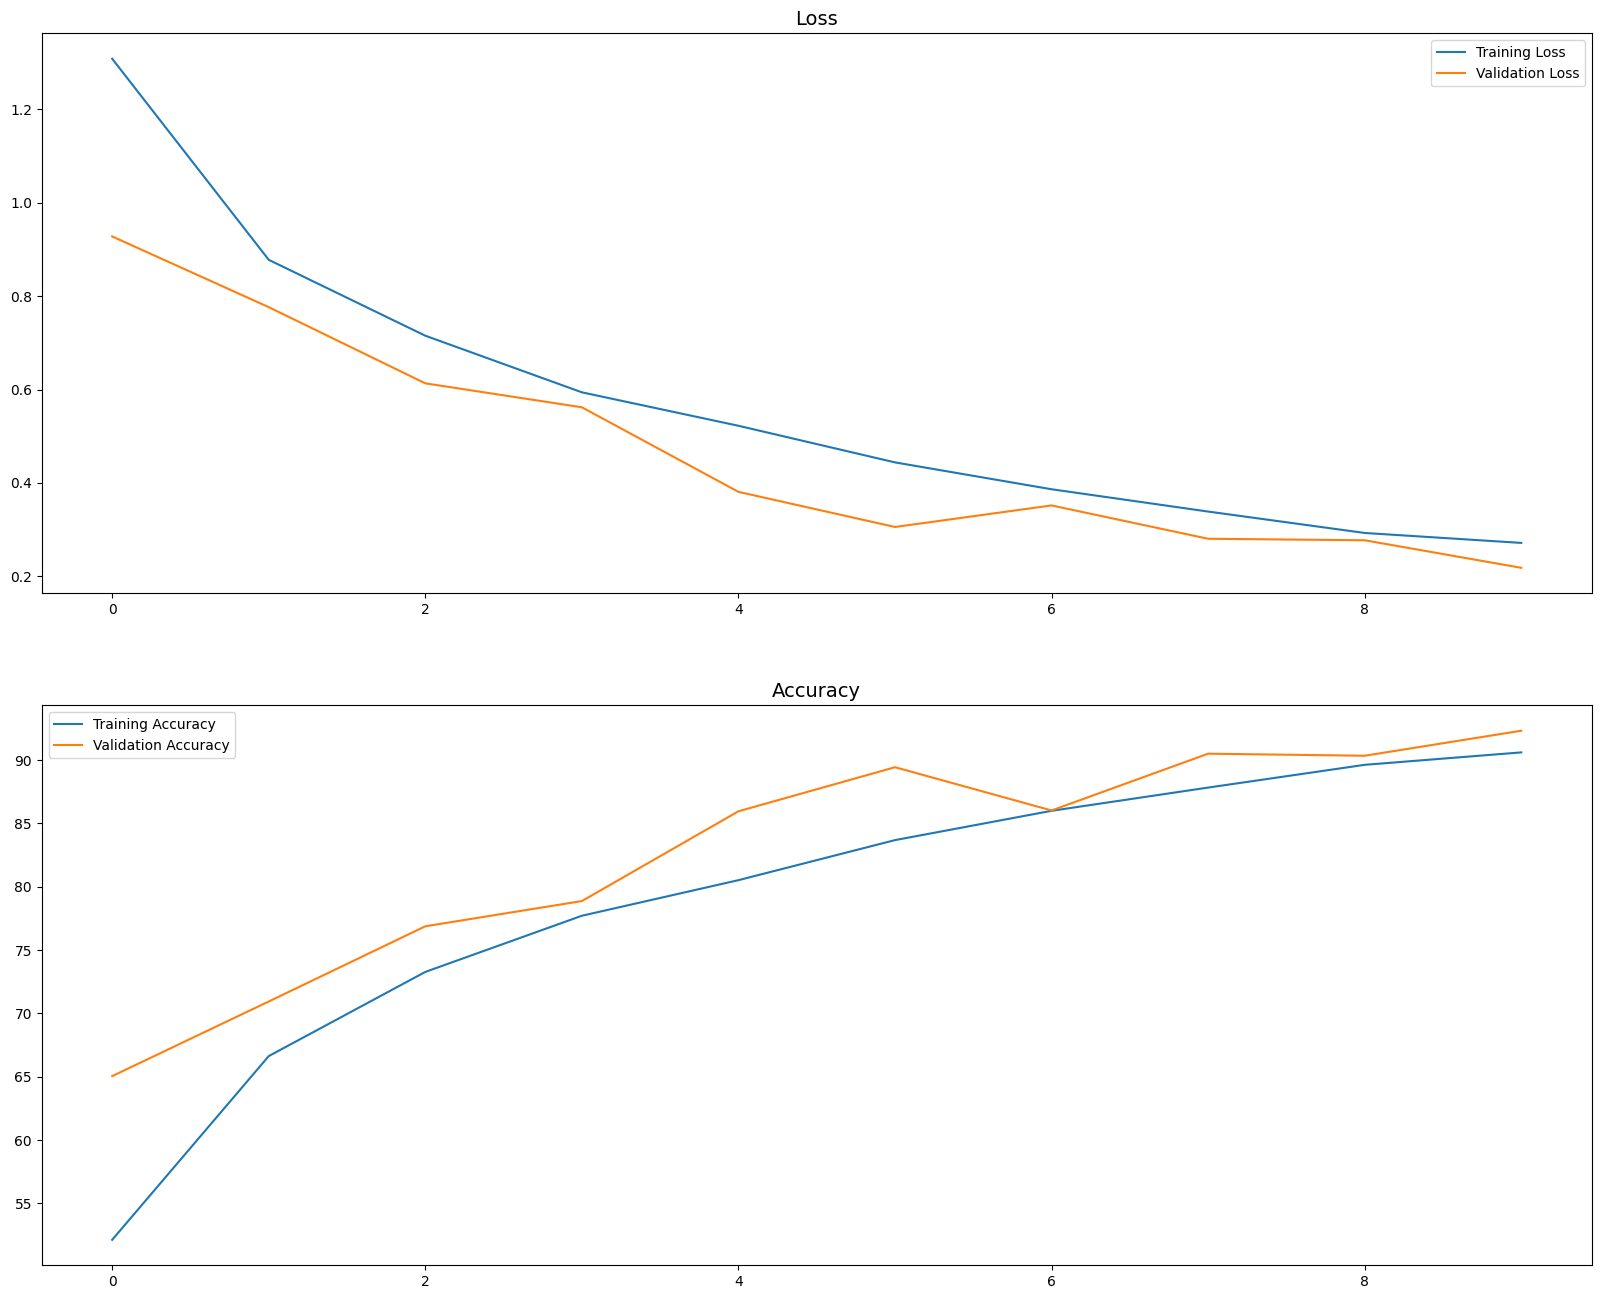

In [36]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy', fontsize=14)  
fig2.legend()
plt.show()

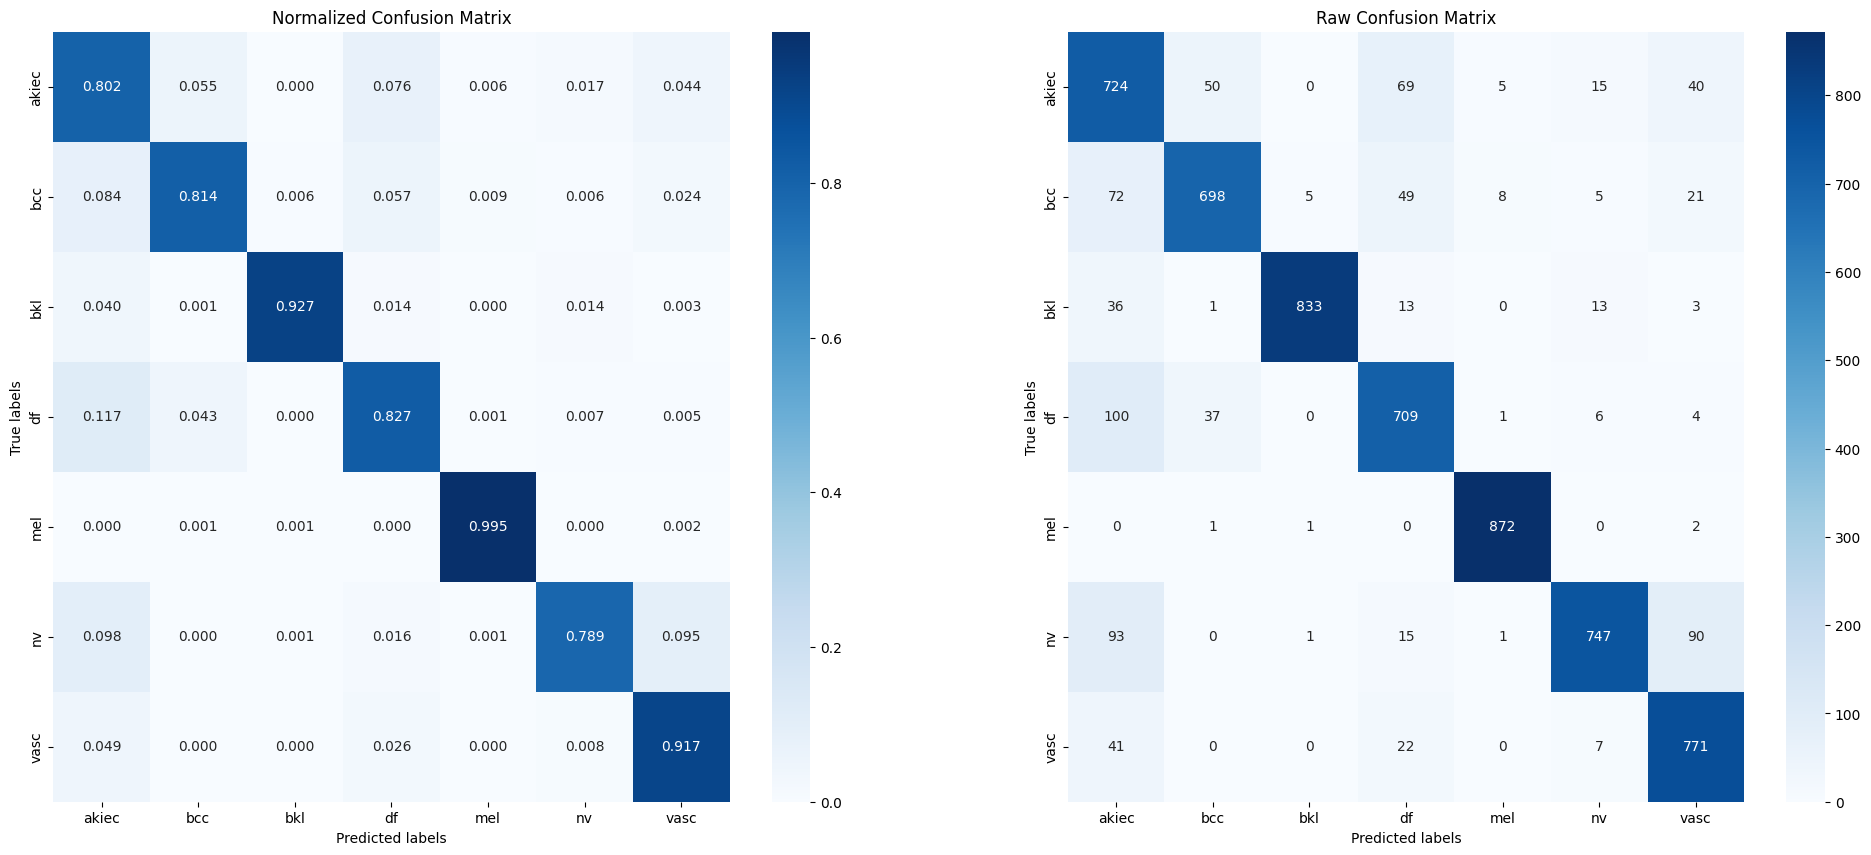

In [50]:
y_pred = []
y_true = []

for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)
    output = CNN_model(data)
    output = output.max(1)[1].data.cpu().numpy()
    y_pred.extend(output)
    labels = labels.cpu().numpy()
    y_true.extend(labels)

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis], index=classes, columns=classes)

plt.figure(figsize=(24, 10))  

plt.subplot(1, 2, 1)  
sns.heatmap(df_cm, annot=True, fmt=".3f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)  
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Raw Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.savefig('Confusion_Matrix.png')
plt.show()

# Pretrainned model